In [33]:
import pandas as pd
import numpy as np
import os
import sys
from PIL import Image
import random
import tensorflow
import matplotlib.pyplot as plt
from keras.layers import Conv3D, MaxPool3D, Flatten, Dense, MaxPooling2D
from keras.layers import Dropout, Input, BatchNormalization, Reshape, LSTM, TimeDistributed, GRU
from keras.losses import categorical_crossentropy
from keras.callbacks import ReduceLROnPlateau
from keras.models import Model, Sequential
import tensorflow
import keras

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'



In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
AUTOTUNE = tensorflow.data.experimental.AUTOTUNE
ROOT_PATH = "/content/drive/My Drive/Gesture_Assignment/Project_data"

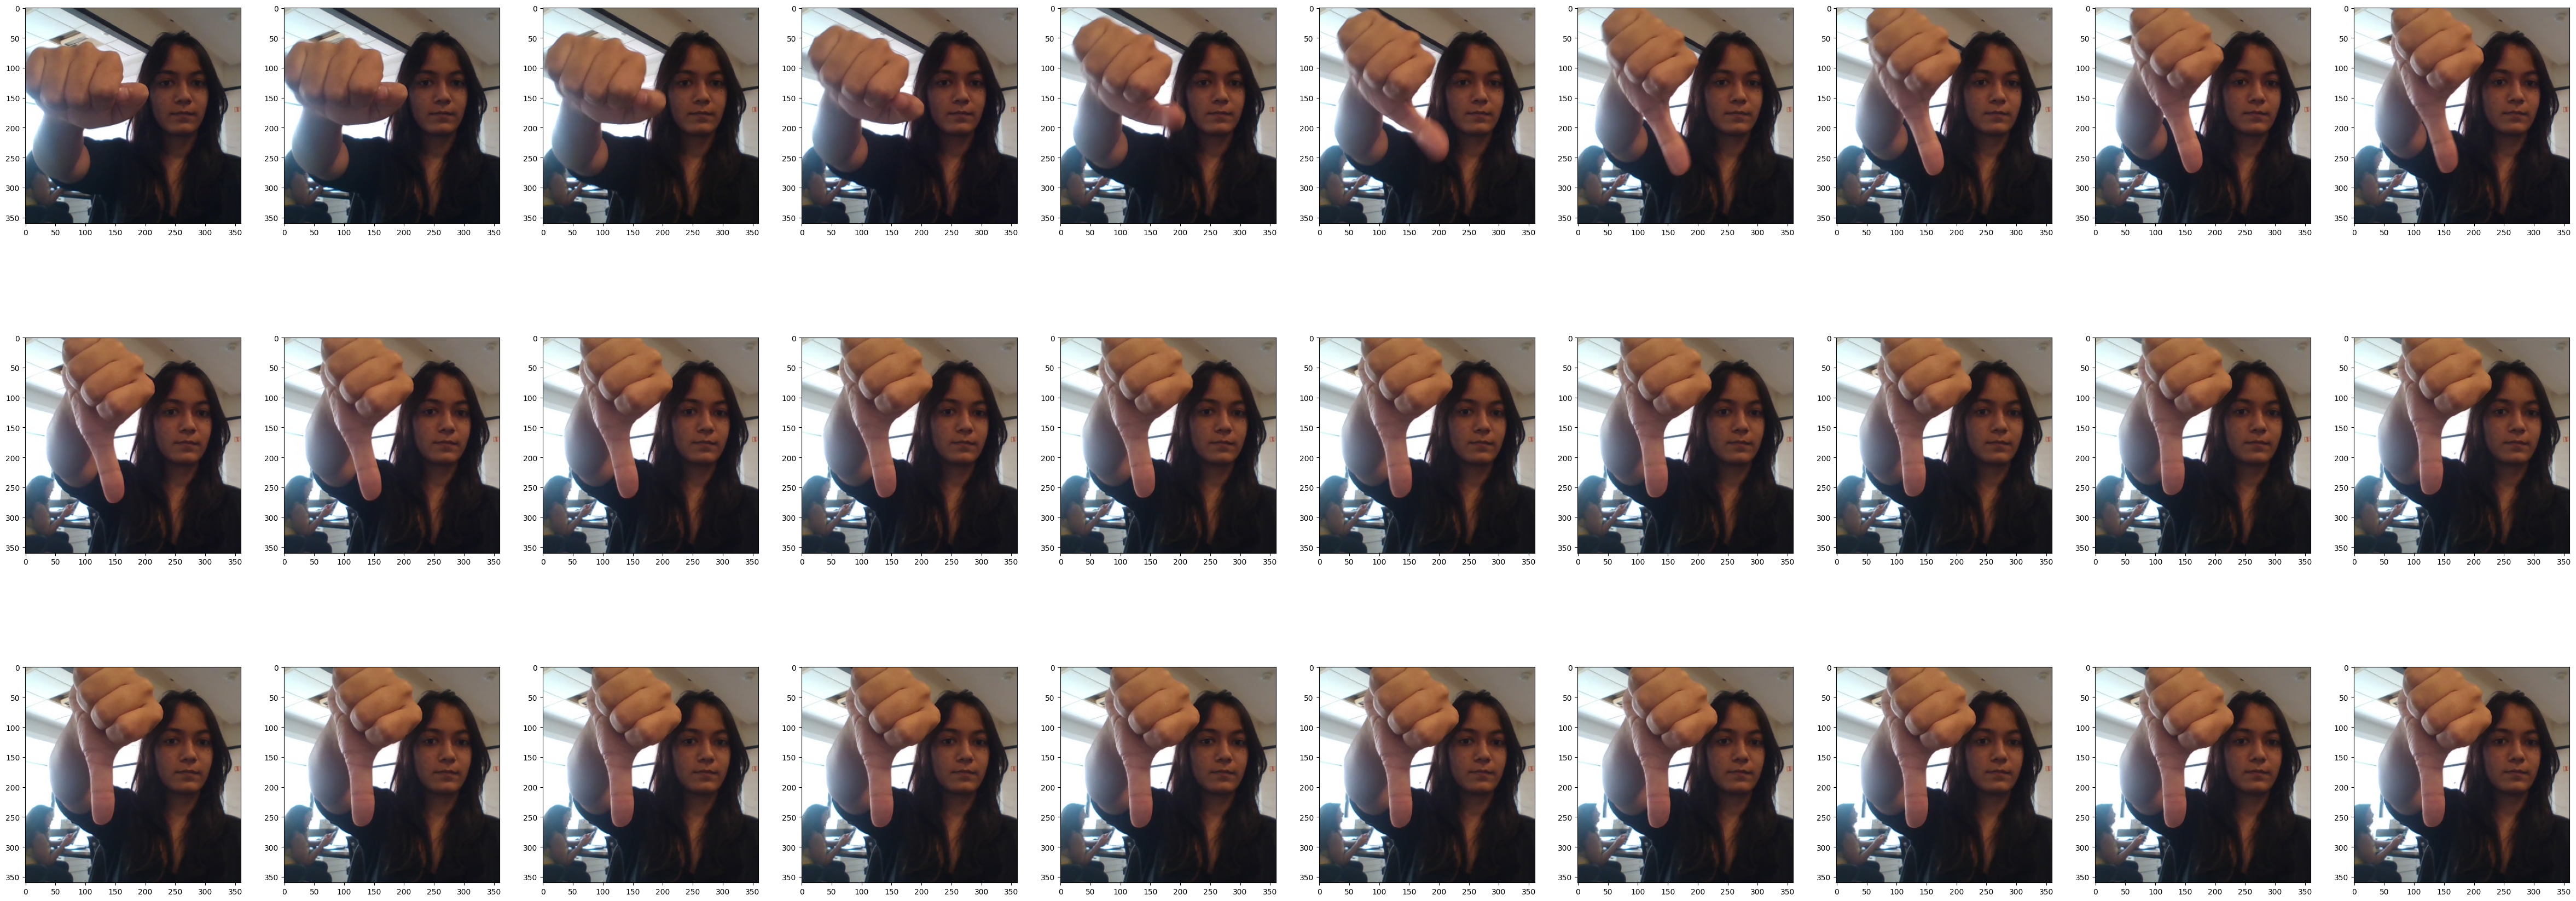

In [ ]:
# Let us inspect sample images to confirm proposed resize 60 X 60 or 60 X 30 can work

import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
from PIL.ExifTags import TAGS

images = []
files = ROOT_PATH + "/train/WIN_20180907_15_44_32_Pro_Thumbs Down_new/*"
for img_path in sorted(glob.glob(files)):
    images.append(mpimg.imread(img_path))

plt.figure(figsize=(60,30))
columns = 10
for i, image in enumerate(images):
    plt.subplot(int(len(images) / columns + 1), columns, i + 1)
    plt.imshow(image)


In [34]:
# We will traverse through Project_data and build 2 DataFrames each for training and validation with below 4 columns
#  Image_File_name | Image_Folder_Name | Image/Gesture_Class_Name | Image/Gesture_Class_label/numerical

# Let us read train.csv and val.csv to build -  folder_name | Gesture_Name | Gesture_Class_label first.

TRAIN_MAPPING = ROOT_PATH + "/train.csv"
VAL_MAPPING = ROOT_PATH + "/val.csv"
img_width, img_height = 64, 64
#img_width, img_height = 128, 128
# we have 30 images, but we chose 28 below leaving aside last two images since they will be bit of repeat. 
num_samples = 28
num_of_channels = 3
num_of_classes = 5
batch_size = 16
    
    
train_map_df = pd.read_csv(TRAIN_MAPPING,sep=";",header=None)
val_map_df = pd.read_csv(VAL_MAPPING,sep=";",header=None)
DF_COLS = ["Folder_Name", "Gesture_Name", "Gesture_Class"]

train_map_df.columns = DF_COLS
val_map_df.columns = DF_COLS

print(train_map_df.tail())
print(val_map_df.tail())


                                 Folder_Name   Gesture_Name  Gesture_Class
658  WIN_20180907_16_38_23_Pro_Thumbs Up_new  Thumbs Up_new              4
659  WIN_20180907_16_41_09_Pro_Thumbs Up_new  Thumbs Up_new              4
660  WIN_20180907_16_42_05_Pro_Thumbs Up_new  Thumbs Up_new              4
661  WIN_20180907_16_42_55_Pro_Thumbs Up_new  Thumbs Up_new              4
662  WIN_20180907_16_43_39_Pro_Thumbs Up_new  Thumbs Up_new              4
                                Folder_Name   Gesture_Name  Gesture_Class
95  WIN_20180907_15_43_36_Pro_Thumbs Up_new  Thumbs Up_new              4
96  WIN_20180907_15_52_05_Pro_Thumbs Up_new  Thumbs Up_new              4
97  WIN_20180907_15_54_30_Pro_Thumbs Up_new  Thumbs Up_new              4
98  WIN_20180907_16_10_59_Pro_Thumbs Up_new  Thumbs Up_new              4
99  WIN_20180907_16_39_59_Pro_Thumbs Up_new  Thumbs Up_new              4


In [35]:
def create_mapping_dataframe(dir_name,input_df):
    
    '''
    We call this function with 'train' and 'val' as dir_name i.e. directory names argument.
    and input_df which has three columns so far. We navigate through each image folder and build data frame.
    This data frame will have 4 columns indicated by df_columns. This dataframe which we return then becomes
    master referrence throughout the program.
    
    Arguments : 
      directory_name - train and val 
      dataframe - created in earlier step with mapping of folder, gesture name and class 
    Returns :
      dataframe - with image file names populated
    '''
    
    train_image_mapping = []
    df_columns = ["Image_File", "Folder_Name", "Gesture_Name", "Gesture_Class"]

    for each_folder in input_df['Folder_Name'].values:
    
        e_gesture_name = input_df.loc[input_df['Folder_Name'] == each_folder ,'Gesture_Name'].values[0]
        e_gesture_class = input_df.loc[input_df['Folder_Name'] == each_folder ,'Gesture_Class'].values[0]
    
        folder_full_path = ROOT_PATH + "/" + dir_name + "/"  + each_folder
        for each_file in os.listdir(folder_full_path):
            train_image_mapping.append((each_file, each_folder, e_gesture_name, e_gesture_class))
            
    return_df = pd.DataFrame(data=train_image_mapping, columns=df_columns)
    
    return return_df

In [36]:
def convert_all_images_to_numpy(df, ops_mode):
    
    '''
    Given the image folder, folder strucutre resize, and convert into numpy array.
    This is efficient method. All numpy arrays are saved in file and generator reads those numpy arrays.
    There is no need to read image for every step in epoch. 

    Arguments:
      df - Dataframe with mapping of folders, image files 
      ops_mode - train or val to indicate location of images
    Returns:
      imagelist in dictionary in multidimensional numpy array 
    '''

    grouped_df = df.groupby('Folder_Name')
    folder_list = grouped_df['Folder_Name'].unique().values.flatten()
    
    image_dict = {}

    count = 0
    for folders in folder_list:
        each_folder = folders[0]
        folder_full_path = ROOT_PATH + "/" + ops_mode + "/"  + each_folder
        file_list_df = grouped_df.get_group(each_folder)['Image_File']
        file_list_tuple = list(zip(file_list_df.index.values, file_list_df.values))
        for each_tuple in file_list_tuple:
            img = Image.open(os.path.join(folder_full_path, each_tuple[1]))
            img = img.resize((img_width, img_height))
            img = np.asarray(img, dtype='uint8')         
            img = img/255.0
            img = np.round(img,5)
            image_dict[each_tuple[0]] = img
            
        print("Finished processing of folder {}".format(count))
        count += 1

    return image_dict

In [37]:
def convert_images_to_numpy_from_dict(image_files, image_dict, df):
    
    '''
    Lookup function - Since we save all images in numpy array, this function, given the image file names, 
    folder strucutre performs lookup of file index into dictionary holding numpy array of all images.
    Arguments:
      image_files - list of image files coming from some folder
      folder - folder name after ROOT_PATH
      ops_mode - train or val to indicate location of images
    Returns:
      imagelist in multidimensional numpy array 
    '''
    grouped_df = df.groupby('Image_File')

    return_images = np.zeros((len(image_files),img_width,img_height,3))
    count = 0 
    for each_file in image_files:
        file_idx = grouped_df.get_group(each_file).index.values[0]
        file_idx = str(file_idx)
        #print(file_idx , type(file_idx))
        #x = image_dict[file_idx]
        return_images[count] = image_dict[file_idx]
    
    return(return_images)

In [44]:
def batch_generator(df, batch_size, ops_mode, image_dict):
    
    '''
    Generate the batch yielding X and y for training via CNN and LSTM.
    Arguments:
      df - dataframe with image_names , and other details like folder names , mapping to gestures etc.
      batch_size - int value indicating how much we want to fit into one batch
      ops_mode - train or val to indicate if we are calling generator for training or validation.
        this operation will change folder structure to refer to 
    Returns:
      Yields batch with X and y values
    '''
    num_samples = 28
    batch_array_size_tuple = (batch_size, num_samples, img_width, img_height, num_of_channels)

    while True:
        

        # Let us shuffle DF to get different sequence of images in every batch if ops_mode is 'train'
        if(ops_mode == 'train'):
            shuffled_df = df.groupby('Folder_Name', group_keys=False).apply(lambda x: x.sample(frac=1))
        else:
            shuffled_df = df.groupby('Folder_Name', group_keys=False).apply(lambda x: x)

        folder_list = shuffled_df['Folder_Name'].unique()
        
        # first for loop below creates batchs and also ensures any residual rows are placed in the last element of array
        # batch X values are of the shape [ batch_size, num_of_samples_per_folder, image_width, image_height, channels ]
        # Batch y values are of the shape [ batch_size, class_labels_in_one_hot ]
        
        folder_batches = []
        for i in range(0, len(folder_list), batch_size):
            folder_batches.append(folder_list[i:i+batch_size])
        
        # Let us iterate through batches and yield X and y for each batch
        for each_batch in folder_batches:
            batch_data = np.zeros(batch_array_size_tuple)
            batch_labels = np.zeros((batch_size,5))

            # we ignore last  frames in sequences thinking it may be repeat. Alternate way is to select alternate image.                 
            # random_imglist = random.sample(range(0, 30), num_samples)
            # random_imglist = sorted(random_imglist)
            # we ignore first seueqnce thinking it may not have captured anything meaningful 
            random_imglist = range(0,num_samples,1)
            #random_imglist = range(0,30,2)
            #num_samples = len(random_imglist)
            
            folder_count = 0
            for each_folder in each_batch:
                img_files = sorted(shuffled_df.groupby('Folder_Name')
                                   .get_group(each_folder)[["Image_File"]]
                                   .values.flatten()
                                  )
                img_files = [img_files[i] for i in random_imglist]
                temp_data = convert_images_to_numpy_from_dict(img_files, image_dict, df)
                batch_data[folder_count] = temp_data
                gesture = int(shuffled_df.groupby('Folder_Name')
                              .get_group(each_folder)['Gesture_Class'].values[0]
                             )
                batch_labels[folder_count, gesture] = 1
                folder_count += 1

            #print("Completed batch {}".format(batch_data.shape))
            yield batch_data, batch_labels


In [39]:
'''
# we create master mapping and store it in dataframe
new_train_map_df = create_mapping_dataframe('train', train_map_df)
new_val_map_df = create_mapping_dataframe('val', val_map_df)
'''

# We have created below two files which have numpy arrays converted from images 
# Due to CPU / GPU requirement , below few lines are commented after map creation.

'''
train_image_dict = {}
val_image_dict = {}
train_image_dict = convert_all_images_to_numpy(new_train_map_df, 'train')
val_image_dict = convert_all_images_to_numpy(new_val_map_df, 'val')

train_image_dict_file = ROOT_PATH + "/" + "train_dict_3.npz"
val_image_dict_file = ROOT_PATH + "/" + "val_dict_3.npz

train_image_dict_str = {str(key): value for key, value in train_image_dict.items()}
np.savez_compressed(train_image_dict_file, **train_image_dict_str)
val_image_dict_str = {str(key): value for key, value in val_image_dict.items()}
np.savez_compressed(val_image_dict_file, **val_image_dict_str)

'''

train_image_dict_file = ROOT_PATH + "/" + "train_dict_3.npz"
val_image_dict_file = ROOT_PATH + "/" + "val_dict_3.npz"

train_image_dict = np.load(train_image_dict_file)
val_image_dict = np.load(val_image_dict_file)

In [40]:
train_mapping_file = ROOT_PATH + "/" + "train_mapping.csv"
val_mapping_file = ROOT_PATH + "/" + "val_mapping.csv"

'''
new_train_map_df.to_csv(train_mapping_file, header=True, sep=",")
new_val_map_df.to_csv(val_mapping_file, header=True, sep=",")
'''

new_train_map_df = pd.read_csv(train_mapping_file, header=0, sep=",", index_col=0)
new_val_map_df = pd.read_csv(val_mapping_file, header=0, sep=",", index_col=0)
print(new_train_map_df.tail())
print(new_val_map_df.tail())

                                Image_File  \
19885  WIN_20180907_16_43_39_Pro_00047.png   
19886  WIN_20180907_16_43_39_Pro_00061.png   
19887  WIN_20180907_16_43_39_Pro_00055.png   
19888  WIN_20180907_16_43_39_Pro_00039.png   
19889  WIN_20180907_16_43_39_Pro_00045.png   

                                   Folder_Name   Gesture_Name  Gesture_Class  
19885  WIN_20180907_16_43_39_Pro_Thumbs Up_new  Thumbs Up_new              4  
19886  WIN_20180907_16_43_39_Pro_Thumbs Up_new  Thumbs Up_new              4  
19887  WIN_20180907_16_43_39_Pro_Thumbs Up_new  Thumbs Up_new              4  
19888  WIN_20180907_16_43_39_Pro_Thumbs Up_new  Thumbs Up_new              4  
19889  WIN_20180907_16_43_39_Pro_Thumbs Up_new  Thumbs Up_new              4  
                               Image_File  \
2995  WIN_20180907_16_39_59_Pro_00053.png   
2996  WIN_20180907_16_39_59_Pro_00019.png   
2997  WIN_20180907_16_39_59_Pro_00035.png   
2998  WIN_20180907_16_39_59_Pro_00041.png   
2999  WIN_20180907_16_39

[[[0.47059 0.47059 0.43137]
  [0.46667 0.47059 0.41176]
  [0.46667 0.46275 0.41961]
  ...
  [0.5451  0.52549 0.5098 ]
  [0.54118 0.52157 0.49412]
  [0.52157 0.52157 0.47059]]

 [[0.51373 0.51765 0.47451]
  [0.51373 0.51373 0.46667]
  [0.50588 0.50196 0.4549 ]
  ...
  [0.53725 0.51765 0.4902 ]
  [0.53333 0.5098  0.47843]
  [0.51765 0.5098  0.46275]]

 [[0.5451  0.54902 0.50588]
  [0.5451  0.54118 0.51373]
  [0.54118 0.54118 0.4902 ]
  ...
  [0.52941 0.51373 0.47059]
  [0.52157 0.49804 0.45882]
  [0.51765 0.49804 0.4549 ]]

 ...

 [[0.49412 0.39608 0.37647]
  [0.38824 0.28235 0.25882]
  [0.28627 0.16863 0.18824]
  ...
  [0.26275 0.2     0.2    ]
  [0.29412 0.20784 0.21569]
  [0.29412 0.20392 0.21569]]

 [[0.39608 0.3098  0.27843]
  [0.28235 0.16863 0.16078]
  [0.12941 0.0549  0.06275]
  ...
  [0.27059 0.19608 0.19608]
  [0.28627 0.20392 0.20784]
  [0.26275 0.2     0.18824]]

 [[0.16471 0.12549 0.11373]
  [0.1451  0.06667 0.08235]
  [0.15294 0.05098 0.08235]
  ...
  [0.28627 0.19608 0.196

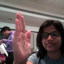

In [41]:
# Inspect one sample array and also convert it back into image to confirm scaling etc. is working 
print(train_image_dict['15570'],train_image_dict['15570'].shape)

i_img = (train_image_dict['15576']*255).astype(np.uint8)
im = Image.fromarray(i_img, mode="RGB")
im.show()

In [42]:
train_size = len(train_map_df)
val_size = len(val_map_df)

if (train_size%batch_size) == 0:
    steps_per_epoch = int(train_size/batch_size)
else:
    steps_per_epoch = (train_size//batch_size) + 1

if (val_size%batch_size) == 0:
    validation_steps = int(val_size/batch_size)
else:
    validation_steps = (val_size//batch_size) + 1

In [43]:
print(train_size,val_size,steps_per_epoch,validation_steps)

663 100 42 7


In [ ]:
#print(new_train_map_df.head(), new_val_map_df.tail)

In [39]:
train_batch_generator =  batch_generator(new_train_map_df, batch_size, 'train', train_image_dict)
val_batch_generator =  batch_generator(new_val_map_df, batch_size, 'val', val_image_dict)

In [ ]:
# Let us try video classification using conv3D model

input_size_tuple = (num_samples, img_width, img_height, num_of_channels)

# input layer
input_layer = Input(input_size_tuple)
# Conv layers
conv_layer1 = Conv3D(filters=8, kernel_size=(3, 3, 3), activation='relu')(input_layer)
conv_layer2 = Conv3D(filters=16, kernel_size=(3, 3, 3), activation='relu')(conv_layer1)
# max pooling layer
pooling_layer1 = MaxPool3D(pool_size=(2, 2, 2))(conv_layer2)

conv_layer3 = Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu')(pooling_layer1)
conv_layer4 = Conv3D(filters=64, kernel_size=(3, 3, 3), activation='relu')(conv_layer3)
pooling_layer2 = MaxPool3D(pool_size=(2, 2, 2))(conv_layer4)

#pooling_layer2 = BatchNormalization()(pooling_layer2)
flatten_layer = Flatten()(pooling_layer2)

## add dropouts to avoid overfitting / perform regularization
dense_layer1 = Dense(units=128, activation='relu')(flatten_layer)
dense_layer1 = Dropout(0.2)(dense_layer1)
dense_layer2 = Dense(units=64, activation='relu')(dense_layer1)
dense_layer2 = Dropout(0.2)(dense_layer2)
output_layer = Dense(units=num_of_classes, activation='softmax')(dense_layer1)

model = Model(inputs=input_layer, outputs=output_layer)



In [ ]:
model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 28, 64, 64, 3)]   0         
                                                                 
 conv3d_24 (Conv3D)          (None, 26, 62, 62, 8)     656       
                                                                 
 conv3d_25 (Conv3D)          (None, 24, 60, 60, 16)    3472      
                                                                 
 max_pooling3d_12 (MaxPoolin  (None, 12, 30, 30, 16)   0         
 g3D)                                                            
                                                                 
 conv3d_26 (Conv3D)          (None, 10, 28, 28, 32)    13856     
                                                                 
 conv3d_27 (Conv3D)          (None, 8, 26, 26, 64)     55360     
                                                           

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.callbacks import History

opt = keras.optimizers.Adam(learning_rate=0.0005)
model.compile(loss=categorical_crossentropy, optimizer=opt, metrics=["acc"])

history = History()

epochs = 50

# let us create checkpoint so that weights and model configuration are saved after every epoch
checkpoint_filepath = ROOT_PATH + "/" + "ccn_checkpoint_1.h5"
checkpoint = ModelCheckpoint(checkpoint_filepath, save_weights_only=False)



In [ ]:
model.fit(train_batch_generator, validation_data=val_batch_generator, 
                steps_per_epoch=steps_per_epoch, validation_steps=validation_steps, epochs=epochs, 
                verbose=1, callbacks=[checkpoint, history])

Epoch 1/50
42/42 [==============================] - 63s 1s/step - loss: 1.5916 - acc: 0.1845 - val_loss: 1.4359 - val_acc: 0.2679
Epoch 2/50
42/42 [==============================] - 52s 1s/step - loss: 1.5833 - acc: 0.2024 - val_loss: 1.4090 - val_acc: 0.2054
Epoch 3/50
42/42 [==============================] - 52s 1s/step - loss: 1.5543 - acc: 0.2589 - val_loss: 1.3444 - val_acc: 0.2232
Epoch 4/50
42/42 [==============================] - 52s 1s/step - loss: 1.4984 - acc: 0.2738 - val_loss: 1.2941 - val_acc: 0.3839
Epoch 5/50
42/42 [==============================] - 52s 1s/step - loss: 1.4066 - acc: 0.3810 - val_loss: 1.1864 - val_acc: 0.4107
Epoch 6/50
42/42 [==============================] - 52s 1s/step - loss: 1.3342 - acc: 0.4211 - val_loss: 1.1071 - val_acc: 0.4375
Epoch 7/50
42/42 [==============================] - 51s 1s/step - loss: 1.2476 - acc: 0.4807 - val_loss: 1.0522 - val_acc: 0.4375
Epoch 8/50
42/42 [==============================] - 51s 1s/step - loss: 1.1805 - acc: 0.51

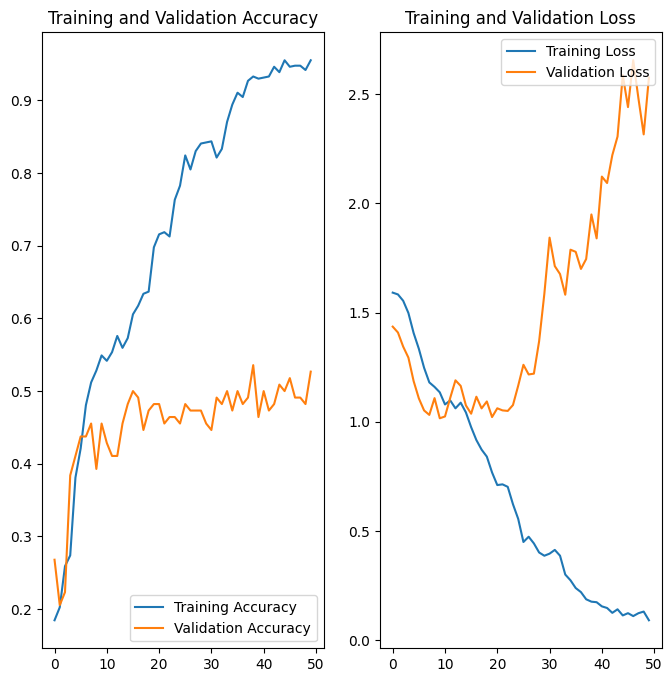

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [20]:
# Let us try video classification using conv3D model
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation,Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.optimizers import Adam

num_samples = 15
input_size_tuple = (num_samples, img_width, img_height, num_of_channels)

model_conv3d = Sequential()

model_conv3d.add(Conv3D(8, kernel_size=(3,3,3), input_shape=input_size_tuple, padding='same'))
model_conv3d.add(BatchNormalization())
model_conv3d.add(Activation('relu'))
model_conv3d.add(Dropout(0.25))

model_conv3d.add(MaxPooling3D(pool_size=(2,2,2)))

model_conv3d.add(Conv3D(16, kernel_size=(3,3,3), padding='same'))
model_conv3d.add(BatchNormalization())
model_conv3d.add(Activation('relu'))
model_conv3d.add(Dropout(0.25))

model_conv3d.add(MaxPooling3D(pool_size=(2,2,2)))

model_conv3d.add(Conv3D(32, kernel_size=(1,3,3), padding='same'))
model_conv3d.add(BatchNormalization())
model_conv3d.add(Activation('relu'))
model_conv3d.add(Dropout(0.25))

model_conv3d.add(MaxPooling3D(pool_size=(2,2,2)))

model_conv3d.add(Conv3D(64, kernel_size=(1,3,3), padding='same'))
model_conv3d.add(Activation('relu'))
model_conv3d.add(Dropout(0.25))

model_conv3d.add(MaxPooling3D(pool_size=(1,2,2)))

#Flatten Layers
model_conv3d.add(Flatten())

model_conv3d.add(Dense(256, activation='relu'))
model_conv3d.add(Dropout(0.5))

model_conv3d.add(Dense(128, activation='relu'))
model_conv3d.add(Dropout(0.5))

#softmax layer
model_conv3d.add(Dense(num_of_classes, activation='softmax'))



In [21]:
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.callbacks import History

opt = keras.optimizers.Adam(learning_rate=0.0005)
model_conv3d.compile(loss=categorical_crossentropy, optimizer=opt, metrics=["acc"])

history = History()

epochs = 50

# let us create checkpoint so that weights and model configuration are saved after every epoch
checkpoint_filepath = ROOT_PATH + "/" + "ccn_checkpoint_2.h5"
checkpoint = ModelCheckpoint(checkpoint_filepath, save_weights_only=False)


In [23]:
batch_size = 16
train_batch_generator =  batch_generator(new_train_map_df, batch_size, 'train', train_image_dict)
val_batch_generator =  batch_generator(new_val_map_df, batch_size, 'val', val_image_dict)

model_conv3d.fit(train_batch_generator, validation_data=val_batch_generator, 
                steps_per_epoch=steps_per_epoch, validation_steps=validation_steps, epochs=epochs, 
                verbose=1, callbacks=[checkpoint, history])

Epoch 1/50
42/42 [==============================] - 53s 1s/step - loss: 2.2391 - acc: 0.2098 - val_loss: 1.4381 - val_acc: 0.1875
Epoch 2/50
42/42 [==============================] - 41s 1s/step - loss: 1.5876 - acc: 0.2470 - val_loss: 1.4424 - val_acc: 0.1875
Epoch 3/50
42/42 [==============================] - 41s 1s/step - loss: 1.5883 - acc: 0.2530 - val_loss: 1.4450 - val_acc: 0.1429
Epoch 4/50
42/42 [==============================] - 41s 1s/step - loss: 1.5765 - acc: 0.2500 - val_loss: 1.4628 - val_acc: 0.1429
Epoch 5/50
42/42 [==============================] - 41s 1s/step - loss: 1.5235 - acc: 0.2857 - val_loss: 1.4817 - val_acc: 0.1429
Epoch 6/50
42/42 [==============================] - 41s 997ms/step - loss: 1.5155 - acc: 0.3185 - val_loss: 1.5704 - val_acc: 0.1429
Epoch 7/50
42/42 [==============================] - 41s 993ms/step - loss: 1.4739 - acc: 0.3363 - val_loss: 1.6967 - val_acc: 0.1429
Epoch 8/50
42/42 [==============================] - 42s 1s/step - loss: 1.4311 - acc

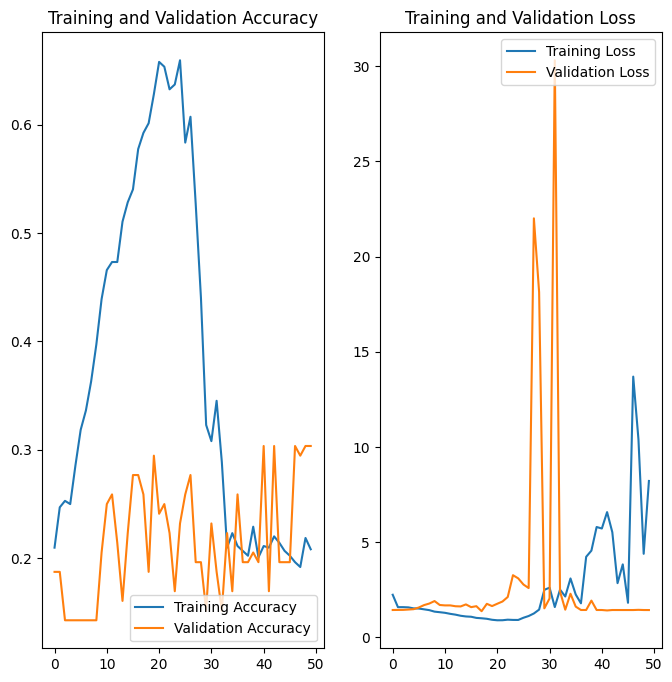

In [31]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

II .** **3D CNN + RNN (GRU)**

In [33]:
# 3D CNN + LSTM
# Let us try video classification using conv3D model - another method

num_samples = 28
num_of_channels = 3
num_of_classes = 5
batch_size = 32

img_width, img_height = 64, 64


input_size_tuple = (num_samples, img_width, img_height, num_of_channels)

# input layer
input_layer = Input(input_size_tuple)
# Conv layers
conv_layer1 = Conv3D(filters=8, kernel_size=(2, 2, 2), activation='relu')(input_layer)
conv_layer2 = Conv3D(filters=16, kernel_size=(2, 2, 2), activation='relu')(conv_layer1)
# max pooling layer
pooling_layer1 = MaxPool3D(pool_size=(2, 2, 2))(conv_layer2)

conv_layer3 = Conv3D(filters=32, kernel_size=(2, 2, 2), activation='relu')(pooling_layer1)
conv_layer4 = Conv3D(filters=64, kernel_size=(2, 2, 2), activation='relu')(conv_layer3)
pooling_layer2 = MaxPool3D(pool_size=(2, 2, 2))(conv_layer4)

#pooling_layer2 = BatchNormalization()(pooling_layer2)

flatten_layer = Flatten()(pooling_layer2)
print(flatten_layer.shape)

timesteps = 28
input_dim = flatten_layer.shape[1] // timesteps

# Reshape to (batch_size, timesteps, input_dim)


flatten_layer = Reshape((timesteps, input_dim) )(flatten_layer)

lstm_layer1 = LSTM(64, return_sequences=True)(flatten_layer)
lstm_layer2 = LSTM(16, return_sequences=False)(lstm_layer1)


## add dropouts to avoid overfitting / perform regularization
dense_layer1 = Dense(units=128, activation='relu')(lstm_layer2)
dense_layer1 = Dropout(0.4)(dense_layer1)
#dense_layer2 = Dense(units=64, activation='relu')(dense_layer1)
#dense_layer2 = Dropout(0.4)(dense_layer2)

output_layer = Dense(units=num_of_classes, activation='softmax')(dense_layer1)
model = Model(inputs=input_layer, outputs=output_layer)


(None, 62720)


In [34]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.0005)
opt = keras.optimizers.Adam(learning_rate=0.0005)

model.compile(loss=categorical_crossentropy, optimizer=opt, metrics=['acc'])

In [35]:
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.callbacks import History 
history = History()

epochs = 50

# let us create checkpoint so that weights are saved after every epoch
checkpoint_filepath = ROOT_PATH + "/" + "ccn_checkpoint_3.h5"
checkpoint = ModelCheckpoint(checkpoint_filepath, save_weights_only=True)

In [36]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 64, 64, 3)]   0         
                                                                 
 conv3d_12 (Conv3D)          (None, 27, 63, 63, 8)     200       
                                                                 
 conv3d_13 (Conv3D)          (None, 26, 62, 62, 16)    1040      
                                                                 
 max_pooling3d_10 (MaxPoolin  (None, 13, 31, 31, 16)   0         
 g3D)                                                            
                                                                 
 conv3d_14 (Conv3D)          (None, 12, 30, 30, 32)    4128      
                                                                 
 conv3d_15 (Conv3D)          (None, 11, 29, 29, 64)    16448     
                                                           

In [40]:
#with tensorflow.device('/CPU:0'):
model.fit(train_batch_generator, validation_data=val_batch_generator, 
                steps_per_epoch=steps_per_epoch, validation_steps=validation_steps, epochs=epochs, 
                verbose=1, callbacks=[checkpoint, history, reduce_lr])

Epoch 1/50
42/42 [==============================] - 113s 3s/step - loss: 1.5884 - acc: 0.2046 - val_loss: 1.4081 - val_acc: 0.2812 - lr: 5.0000e-04
Epoch 2/50
42/42 [==============================] - 106s 3s/step - loss: 1.5871 - acc: 0.2061 - val_loss: 1.4057 - val_acc: 0.2812 - lr: 5.0000e-04
Epoch 3/50
42/42 [==============================] - 107s 3s/step - loss: 1.5643 - acc: 0.2158 - val_loss: 1.3931 - val_acc: 0.1607 - lr: 5.0000e-04
Epoch 4/50
42/42 [==============================] - 107s 3s/step - loss: 1.4789 - acc: 0.2909 - val_loss: 1.3250 - val_acc: 0.2768 - lr: 5.0000e-04
Epoch 5/50
42/42 [==============================] - 106s 3s/step - loss: 1.4276 - acc: 0.3147 - val_loss: 1.2263 - val_acc: 0.3348 - lr: 5.0000e-04
Epoch 6/50
42/42 [==============================] - 106s 3s/step - loss: 1.3593 - acc: 0.3557 - val_loss: 1.1825 - val_acc: 0.3438 - lr: 5.0000e-04
Epoch 7/50
42/42 [==============================] - 106s 3s/step - loss: 1.3184 - acc: 0.3624 - val_loss: 1.1701

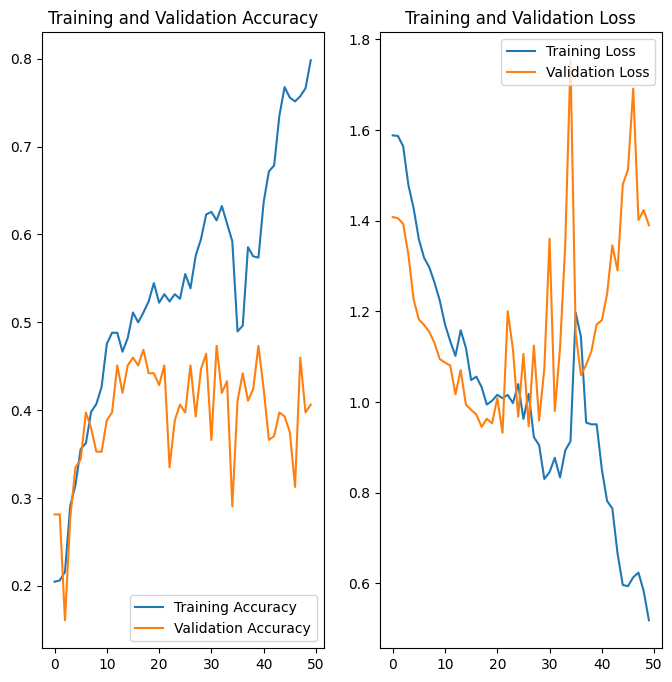

In [41]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
III. CNN2D + RNN (GRU)

In [49]:
# Let us try video classification using conv2D model + RNN - another method
num_samples = 28
num_of_channels = 3
num_of_classes = 5
batch_size =16

img_width, img_height = 64, 64

# Let us try video classification using conv2D model + RNN - another method

input_size_tuple = (num_samples, img_width, img_height, num_of_channels)

from keras.layers import Conv2D, BatchNormalization, MaxPool2D, GlobalMaxPool2D

def build_convnet(shape=(img_width, img_height, num_of_channels)):
    momentum = .9
    model = keras.Sequential()
    model.add(Conv2D(64, (3,3), input_shape=shape,
        padding='same', activation='relu'))
    model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
    #model.add(BatchNormalization(momentum=momentum))
    
    model.add(MaxPool2D())
    
    model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
    model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
    #model.add(BatchNormalization(momentum=momentum))
    
    model.add(MaxPool2D())
    
    model.add(Conv2D(256, (3,3), padding='same', activation='relu'))
    model.add(Conv2D(256, (3,3), padding='same', activation='relu'))
    #model.add(BatchNormalization(momentum=momentum))
    
    model.add(MaxPool2D())
    
    model.add(Conv2D(512, (3,3), padding='same', activation='relu'))
    model.add(Conv2D(512, (3,3), padding='same', activation='relu'))
    #model.add(BatchNormalization(momentum=momentum))
    
    # flatten...
    model.add(GlobalMaxPool2D())
    return model


In [50]:
from keras.layers import TimeDistributed, GRU, Dense, Dropout

def action_model(num_of_classes, shape=(num_samples, img_width, img_height, num_of_channels)):
    # Create our convnet with (img_width, img_height, 3) input shape
    convnet = build_convnet(shape[1:])
    
    # then create our final model
    model = keras.Sequential()
    # add the convnet with (number_of_samples, img_widht, img_height, num_of_channels) shape
    model.add(TimeDistributed(convnet, input_shape=shape))
    # here, you can also use GRU or LSTM
    model.add(GRU(64))
    # and finally, we make a decision network
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(.5))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(num_of_classes, activation='softmax'))
    return model

In [51]:

model = action_model(num_of_classes, shape=(num_samples, img_width, img_height, num_of_channels))

'''
optimizer = keras.optimizers.Adam(0.001)
model.compile(
    optimizer,
    'categorical_crossentropy',
    metrics=['acc']
)
'''

"\noptimizer = keras.optimizers.Adam(0.001)\nmodel.compile(\n    optimizer,\n    'categorical_crossentropy',\n    metrics=['acc']\n)\n"

In [52]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_1 (TimeDis  (None, 28, 512)          4685376   
 tributed)                                                       
                                                                 
 gru_1 (GRU)                 (None, 64)                110976    
                                                                 
 dense_15 (Dense)            (None, 1024)              66560     
                                                                 
 dropout_17 (Dropout)        (None, 1024)              0         
                                                                 
 dense_16 (Dense)            (None, 512)               524800    
                                                                 
 dropout_18 (Dropout)        (None, 512)               0         
                                                      

In [53]:
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.callbacks import History 
history = History()

epochs = 50

# let us create checkpoint so that weights are saved after every epoch
checkpoint_filepath = ROOT_PATH + "/" + "ccn_checkpoint_4.h5"
checkpoint = ModelCheckpoint(checkpoint_filepath, save_weights_only=False)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.0005)
opt = keras.optimizers.Adam(learning_rate=0.0005)

model.compile(loss=categorical_crossentropy, optimizer=opt, metrics=['acc'])


In [54]:
train_batch_generator =  batch_generator(new_train_map_df, batch_size, 'train', train_image_dict)
val_batch_generator =  batch_generator(new_val_map_df, batch_size, 'val', val_image_dict)

In [55]:
model.fit(train_batch_generator, validation_data=val_batch_generator, 
          steps_per_epoch=steps_per_epoch, validation_steps=validation_steps, epochs=epochs, verbose=1, callbacks=[checkpoint, history, reduce_lr])

Epoch 1/50
42/42 [==============================] - 56s 1s/step - loss: 1.5883 - acc: 0.2068 - val_loss: 1.4367 - val_acc: 0.2679 - lr: 5.0000e-04
Epoch 2/50
42/42 [==============================] - 53s 1s/step - loss: 1.5885 - acc: 0.2173 - val_loss: 1.4361 - val_acc: 0.2054 - lr: 5.0000e-04
Epoch 3/50
42/42 [==============================] - 54s 1s/step - loss: 1.5886 - acc: 0.1905 - val_loss: 1.4353 - val_acc: 0.2054 - lr: 5.0000e-04
Epoch 4/50
42/42 [==============================] - 54s 1s/step - loss: 1.5882 - acc: 0.2039 - val_loss: 1.4362 - val_acc: 0.2054 - lr: 5.0000e-04
Epoch 5/50
42/42 [==============================] - 54s 1s/step - loss: 1.5908 - acc: 0.1890 - val_loss: 1.4356 - val_acc: 0.2054 - lr: 5.0000e-04
Epoch 6/50
42/42 [==============================] - 54s 1s/step - loss: 1.5869 - acc: 0.2009 - val_loss: 1.4351 - val_acc: 0.2054 - lr: 5.0000e-04
Epoch 7/50
42/42 [==============================] - 53s 1s/step - loss: 1.5881 - acc: 0.1964 - val_loss: 1.4355 - val_

In [ ]:
# Transfer Learning + LSTM

In [13]:
mnet = tensorflow.keras.applications.MobileNet(
    include_top=False,
    weights='imagenet',
    input_shape=(128, 128, 3)
)

In [14]:
# Since mnet needs images in 128 X 128 or 256 X 256 shape, we need to create numpy arrays from images of this renewed size
# Let us choose 128 X 128
def tr_convert_all_images_to_numpy(df, ops_mode):
    
    '''
    Given the image folder, folder strucutre resize, and convert into numpy array.
    This is efficient method. All numpy arrays are saved in file and generator reads those numpy arrays.
    There is no need to read image for every step in epoch. 

    Arguments:
      df - Dataframe with mapping of folders, image files 
      ops_mode - train or val to indicate location of images
    Returns:
      imagelist in dictionary in multidimensional numpy array 
    '''
    img_width, img_height = 128, 128
    grouped_df = df.groupby('Folder_Name')
    folder_list = grouped_df['Folder_Name'].unique().values.flatten()
    
    image_dict = {}

    count = 0
    for folders in folder_list:
        each_folder = folders[0]
        folder_full_path = ROOT_PATH + "/" + ops_mode + "/"  + each_folder
        file_list_df = grouped_df.get_group(each_folder)['Image_File']
        file_list_tuple = list(zip(file_list_df.index.values, file_list_df.values))
        for each_tuple in file_list_tuple:
            img = Image.open(os.path.join(folder_full_path, each_tuple[1]))
            img = img.resize((img_width, img_height))
            img = np.asarray(img, dtype='uint8')         
            img = img/255.0
            img = np.round(img,5)
            image_dict[each_tuple[0]] = img
            
        print("Finished processing of folder {}".format(count))
        count += 1

    return image_dict

In [17]:

'''
tr_train_image_dict = {}
tr_val_image_dict = {}

tr_train_image_dict = tr_convert_all_images_to_numpy(new_train_map_df, 'train')
tr_val_image_dict = tr_convert_all_images_to_numpy(new_val_map_df, 'val')

tr_train_image_dict_file = ROOT_PATH + "/" + "tr_train_dict_3.npz"
tr_val_image_dict_file = ROOT_PATH + "/" + "tr_val_dict_3.npz"

train_image_dict_str = {str(key): value for key, value in tr_train_image_dict.items()}
np.savez_compressed(tr_train_image_dict_file, **train_image_dict_str)
val_image_dict_str = {str(key): value for key, value in tr_val_image_dict.items()}
np.savez_compressed(tr_val_image_dict_file, **val_image_dict_str)
'''

train_image_dict_file = ROOT_PATH + "/" + "tr_train_dict_3.npz"
val_image_dict_file = ROOT_PATH + "/" + "tr_val_dict_3.npz"

tr_train_image_dict = np.load(train_image_dict_file)
tr_val_image_dict = np.load(val_image_dict_file)



In [18]:
for layer in mnet.layers:
    layer.trainable = False

In [27]:
from keras.models import Sequential
input_size_tuple = (num_samples, img_width, img_height, num_of_channels)

no_classes = 5 
model_transfer_learning = Sequential()
model_transfer_learning.add(TimeDistributed(mnet,input_shape=input_size_tuple))
 
        
model_transfer_learning.add(TimeDistributed(BatchNormalization()))
model_transfer_learning.add(TimeDistributed(MaxPooling2D((2, 2))))
model_transfer_learning.add(TimeDistributed(Flatten()))

model_transfer_learning.add(GRU(64))
model_transfer_learning.add(Dropout(0.2))
        
model_transfer_learning.add(Dense(64,activation='relu'))
model_transfer_learning.add(Dropout(0.2))
        
model_transfer_learning.add(Dense(5, activation='softmax'))
        
        
optimiser = keras.optimizers.Adam(learning_rate=0.005)
model_transfer_learning.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
 

In [28]:
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.callbacks import History 
history = History()

epochs = 50

# let us create checkpoint so that weights are saved after every epoch
checkpoint_filepath = ROOT_PATH + "/" + "ccn_checkpoint_5.h5"
checkpoint = ModelCheckpoint(checkpoint_filepath, save_weights_only=False)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.0005)
opt = keras.optimizers.Adam(learning_rate=0.0005)

model_transfer_learning.compile(loss=categorical_crossentropy, optimizer=opt, metrics=['acc'])

In [30]:
model_transfer_learning.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_10 (TimeDi  (None, 28, 4, 4, 1024)   3228864   
 stributed)                                                      
                                                                 
 time_distributed_11 (TimeDi  (None, 28, 4, 4, 1024)   4096      
 stributed)                                                      
                                                                 
 time_distributed_12 (TimeDi  (None, 28, 2, 2, 1024)   0         
 stributed)                                                      
                                                                 
 time_distributed_13 (TimeDi  (None, 28, 4096)         0         
 stributed)                                                      
                                                                 
 gru_1 (GRU)                 (None, 64)               

In [45]:
batch_size = 16
train_batch_generator =  batch_generator(new_train_map_df, batch_size, 'train', tr_train_image_dict)
val_batch_generator =  batch_generator(new_val_map_df, batch_size, 'val', tr_val_image_dict)

model_transfer_learning.fit(train_batch_generator, validation_data=val_batch_generator, 
                steps_per_epoch=steps_per_epoch, validation_steps=validation_steps, epochs=epochs, 
                verbose=1, callbacks=[checkpoint, history])

Epoch 1/50
42/42 [==============================] - 86s 2s/step - loss: 1.6031 - acc: 0.2128 - val_loss: 1.4198 - val_acc: 0.1964
Epoch 2/50
42/42 [==============================] - 84s 2s/step - loss: 1.6016 - acc: 0.2143 - val_loss: 1.4237 - val_acc: 0.2411
Epoch 3/50
42/42 [==============================] - 83s 2s/step - loss: 1.5884 - acc: 0.2560 - val_loss: 1.4102 - val_acc: 0.2054
Epoch 4/50
42/42 [==============================] - 84s 2s/step - loss: 1.5680 - acc: 0.2574 - val_loss: 1.3795 - val_acc: 0.2768
Epoch 5/50
42/42 [==============================] - 84s 2s/step - loss: 1.5714 - acc: 0.2336 - val_loss: 1.3518 - val_acc: 0.2232
Epoch 6/50
42/42 [==============================] - 83s 2s/step - loss: 1.5355 - acc: 0.2664 - val_loss: 1.3456 - val_acc: 0.3393
Epoch 7/50
42/42 [==============================] - 83s 2s/step - loss: 1.5092 - acc: 0.2887 - val_loss: 1.3503 - val_acc: 0.4196
Epoch 8/50
42/42 [==============================] - 85s 2s/step - loss: 1.4896 - acc: 0.29

In [46]:
from tensorflow.keras.models import load_model
 
# load model
tr_model = load_model(checkpoint_filepath)

In [47]:
tr_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_10 (TimeDi  (None, 28, 4, 4, 1024)   3228864   
 stributed)                                                      
                                                                 
 time_distributed_11 (TimeDi  (None, 28, 4, 4, 1024)   4096      
 stributed)                                                      
                                                                 
 time_distributed_12 (TimeDi  (None, 28, 2, 2, 1024)   0         
 stributed)                                                      
                                                                 
 time_distributed_13 (TimeDi  (None, 28, 4096)         0         
 stributed)                                                      
                                                                 
 gru_1 (GRU)                 (None, 64)               

In [48]:
batch_size = 16
train_batch_generator =  batch_generator(new_train_map_df, batch_size, 'train', tr_train_image_dict)
val_batch_generator =  batch_generator(new_val_map_df, batch_size, 'val', tr_val_image_dict)

tr_model.fit(train_batch_generator, validation_data=val_batch_generator, 
                steps_per_epoch=steps_per_epoch, validation_steps=validation_steps, epochs=epochs, 
                verbose=1, callbacks=[checkpoint, history])

Epoch 1/50
42/42 [==============================] - 87s 2s/step - loss: 0.5939 - acc: 0.7604 - val_loss: 0.7979 - val_acc: 0.6071
Epoch 2/50
42/42 [==============================] - 85s 2s/step - loss: 0.5264 - acc: 0.8199 - val_loss: 0.8911 - val_acc: 0.5714
Epoch 3/50
42/42 [==============================] - 85s 2s/step - loss: 0.6457 - acc: 0.7574 - val_loss: 0.7017 - val_acc: 0.6429
Epoch 4/50
42/42 [==============================] - 85s 2s/step - loss: 0.5357 - acc: 0.7991 - val_loss: 0.7905 - val_acc: 0.6339
Epoch 5/50
42/42 [==============================] - 85s 2s/step - loss: 0.5234 - acc: 0.8229 - val_loss: 0.7764 - val_acc: 0.5625
Epoch 6/50
42/42 [==============================] - 85s 2s/step - loss: 0.5185 - acc: 0.7917 - val_loss: 0.7645 - val_acc: 0.6250
Epoch 7/50
42/42 [==============================] - 85s 2s/step - loss: 0.4670 - acc: 0.8274 - val_loss: 0.7196 - val_acc: 0.6339
Epoch 8/50
42/42 [==============================] - 86s 2s/step - loss: 0.4341 - acc: 0.86

In [49]:
# load model
tr_model = load_model(checkpoint_filepath)

In [50]:
tr_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_10 (TimeDi  (None, 28, 4, 4, 1024)   3228864   
 stributed)                                                      
                                                                 
 time_distributed_11 (TimeDi  (None, 28, 4, 4, 1024)   4096      
 stributed)                                                      
                                                                 
 time_distributed_12 (TimeDi  (None, 28, 2, 2, 1024)   0         
 stributed)                                                      
                                                                 
 time_distributed_13 (TimeDi  (None, 28, 4096)         0         
 stributed)                                                      
                                                                 
 gru_1 (GRU)                 (None, 64)               

In [51]:
batch_size = 16
train_batch_generator =  batch_generator(new_train_map_df, batch_size, 'train', tr_train_image_dict)
val_batch_generator =  batch_generator(new_val_map_df, batch_size, 'val', tr_val_image_dict)

tr_model.fit(train_batch_generator, validation_data=val_batch_generator, 
                steps_per_epoch=steps_per_epoch, validation_steps=validation_steps, epochs=epochs, 
                verbose=1, callbacks=[checkpoint, history])

Epoch 1/50
42/42 [==============================] - 89s 2s/step - loss: 0.1155 - acc: 0.9568 - val_loss: 1.2441 - val_acc: 0.7500
Epoch 2/50
42/42 [==============================] - 86s 2s/step - loss: 0.1345 - acc: 0.9479 - val_loss: 1.2563 - val_acc: 0.7232
Epoch 3/50
42/42 [==============================] - 86s 2s/step - loss: 0.1283 - acc: 0.9554 - val_loss: 1.2569 - val_acc: 0.6964
Epoch 4/50
42/42 [==============================] - 86s 2s/step - loss: 0.1230 - acc: 0.9494 - val_loss: 1.2823 - val_acc: 0.7589
Epoch 5/50
42/42 [==============================] - 87s 2s/step - loss: 0.1654 - acc: 0.9241 - val_loss: 1.2979 - val_acc: 0.7411
Epoch 6/50
42/42 [==============================] - 86s 2s/step - loss: 0.1306 - acc: 0.9435 - val_loss: 1.2195 - val_acc: 0.7143
Epoch 7/50
42/42 [==============================] - 85s 2s/step - loss: 0.1489 - acc: 0.9479 - val_loss: 1.3417 - val_acc: 0.7232
Epoch 8/50
42/42 [==============================] - 86s 2s/step - loss: 0.1171 - acc: 0.96